In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV
)
from sklearn.model_selection import(
    RepeatedStratifiedKFold,
    cross_val_score,
    GridSearchCV
)
import joblib

In [2]:
dspeech_tok = pd.read_parquet('./data_additionaal/data_speech_tokenized_all.parquet')

In [3]:
dspeech_tok

,index,meeting_id,agenda_item_id,speech_item_id,time_start,time_end,speaker_name,speaker_party,speaker_role,speaker_title,duration,number_of_words,id,tokenized_text,s_i_embeddings
0,0,1,1,1,13:00:56,13:01:34,Anne Baastrup,SF,medlem,Anne Baastrup(SF):,38.0,103,1_1,"[tak, transportminister, optaget, fik, sikkerh...","[-0.03012336159190454, 0.008577189838433696, -..."
1,1,1,1,3,13:01:38,13:02:11,Hans Christian Schmidt,V,minister,Transportministeren(Hans Christian Schmidt):,33.0,97,1_1,"[jamen, godt, spørgsmål, fyn, taler, penge, br...","[-0.025761454500297987, 0.018570666336017894, ..."
2,2,1,1,5,13:02:13,13:02:57,Anne Baastrup,SF,medlem,Anne Baastrup(SF):,44.0,167,1_1,"[glad, høre, transportminister, mente, rent, f...","[-0.014099856570510383, 0.0017362934108859918,..."
3,3,1,1,7,13:03:00,13:03:10,Hans Christian Schmidt,V,minister,Transportministeren(Hans Christian Schmidt):,10.0,46,1_1,"[jamen, spørgeren, siger, klart, forhandlinger...","[-0.017248643160201027, 0.003410065721254796, ..."
4,4,1,1,9,13:03:12,13:03:17,Anne Baastrup,SF,medlem,Anne Baastrup(SF):,5.0,17,1_1,"[rent, spark, sparker, åben, dør, siger, tak, ...","[-0.04360466997604817, 0.011463752947747707, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332063,369757,1787,22,14,15:57:03,15:57:11,Carina Christensen,KF,minister,Kulturministeren(Carina Christensen):,8.0,24,1787_22,"[læst, artikel, børsen, gerne, kigge, leif, la...","[-0.08074926270637661, 0.011464892537333071, 0..."
332064,369758,1787,22,16,15:57:13,15:57:56,Leif Lahn Jensen,S,medlem,Leif Lahn Jensen(S):,43.0,127,1787_22,"[set, svar, ministeren, ministeren, kunnet, ge...","[-0.03352984208322596, 0.014101851153100142, -..."
332065,369759,1787,22,18,15:57:58,15:58:51,Carina Christensen,KF,minister,Kulturministeren(Carina Christensen):,53.0,184,1787_22,"[kulturinstitutionerne, helhed, mærket, forrin...","[-0.015799299580976367, 0.01443920689780498, 0..."
332066,369760,1787,22,20,15:58:56,16:00:05,Mogens Jensen,S,medlem,Mogens Jensen(S):,69.0,165,1787_22,"[altså, ministerens, regnestykke, holder, sige...","[-0.015354743558418704, 0.004704013449554623, ..."


We sample x% of the speech data

In [4]:
X = [0] * len(dspeech_tok)
dspeech_tok["id"] = dspeech_tok["meeting_id"].astype(str) + "_" + dspeech_tok["speaker_party"].astype(str)
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for i, (train_idx, val_idx) in enumerate(stratified_kfold.split(X, dspeech_tok.id.to_list())):
    val_index = list(val_idx)
    dspeech_tok_sample = dspeech_tok.loc[val_index]
    break

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


In [5]:
list_of_words_C = []
with open('data/C_word_list.txt', 'r', encoding='utf-8') as file:
   for item in file:
      list_of_words_C.append(item.strip())
   list_of_words_C = set(list_of_words_C)
      
list_of_words_NC_small = []
with open('data/NC_word_list_small.txt', 'r', encoding='utf-8') as file:
   for item in file:
      list_of_words_NC_small.append(item.strip())
   list_of_words_NC_small = set(list_of_words_NC_small)
      
list_of_words_NC_large = []
with open('data/NC_word_list_large.txt', 'r', encoding='utf-8') as file:
   for item in file:
      list_of_words_NC_large.append(item.strip())
   list_of_words_NC_large = set(list_of_words_NC_large)
      

In [6]:
tokenized_text = dspeech_tok_sample['tokenized_text'].to_list()

count_list = []
def list_of_words_counts(tok_text):
    
    for i in range(len(tok_text)):
        count_C = 0
        count_NC_small = 0
        count_NC_large = 0
        number_of_tokens = 0
    
        for j in range(len(tok_text[i])):
            if tok_text[i][j] in list_of_words_C:
                count_C +=1
            elif tok_text[i][j] in list_of_words_NC_small:
                count_NC_small += 1
            elif tok_text[i][j] in list_of_words_NC_large:
                count_NC_large += 1
        count_list.append([count_C, count_NC_small, count_NC_large, len(tok_text[i])])
    
    return count_list


count_list = list_of_words_counts(tokenized_text)

In [7]:
dspeech_tok_sample[['count_C', 'count_NC_small', 'count_NC_large', 'number_of_tokens']] = count_list 
dspeech_tok_sample['prop_C'] = dspeech_tok_sample['count_C'] / dspeech_tok_sample['number_of_tokens'] 
dspeech_tok_sample['prop_NC_small'] = dspeech_tok_sample['count_NC_small'] / dspeech_tok_sample['number_of_tokens'] 
dspeech_tok_sample['prop_NC_large'] = dspeech_tok_sample['count_NC_large'] / dspeech_tok_sample['number_of_tokens'] 

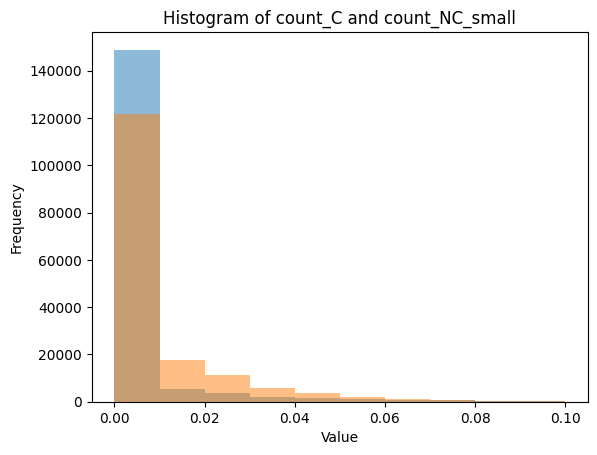

In [8]:
plt.hist(dspeech_tok_sample['prop_C'], range=(0, 0.1), alpha=0.5,  label='count_C')
plt.hist(dspeech_tok_sample['prop_NC_small'], range=(0, 0.1), alpha=0.5, label='count_NC_small')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of count_C and count_NC_small');

In [9]:
#dspeech_tok_sample[(dspeech_tok_sample['count_C']>=3) &
#                   ((dspeech_tok_sample['prop_C']>=0.1) | (dspeech_tok_sample['count_C']>=10)) |
#                   (((dspeech_tok_sample['prop_C']>=0.09))&(dspeech_tok_sample['prop_C']>dspeech_tok_sample['prop_NC_small']))]

In [10]:
pseudoC = dspeech_tok_sample[(dspeech_tok_sample['count_C']>=3) &
                   ((dspeech_tok_sample['prop_C']>=0.1) | (dspeech_tok_sample['count_C']>=10))]
pseudoC['pseudo_label'] = 'C'

C:\Users\ah140\AppData\Local\Temp\ipykernel_17336\4017187693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudoC['pseudo_label'] = 'C'


In [11]:
pseudoNC = dspeech_tok_sample[(dspeech_tok_sample['prop_C']<0.01) | (dspeech_tok_sample['count_C']<=2)]
pseudoNC['pseudo_label'] = 'NC'
pseudoNC = pseudoNC.reset_index(drop=True)

C:\Users\ah140\AppData\Local\Temp\ipykernel_17336\914257054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pseudoNC['pseudo_label'] = 'NC'


In [139]:
def create_training_data(pseudoC_df, pseudoNC_df, ratio):
    X = [0] * len(pseudoNC_df)
    
    nsplits = int(len(pseudoNC_df)/(len(pseudoC_df)*ratio))
    pseudoNC_df["id"] = pseudoNC_df["meeting_id"].astype(str) + "_" + pseudoNC_df["speaker_party"].astype(str)
    stratified_kfold = StratifiedKFold(n_splits=nsplits, shuffle=True, random_state=42)

    for i, (train_idx, val_idx) in enumerate(stratified_kfold.split(X, pseudoNC_df.id.to_list())):
        val_index = list(val_idx)
        pseudoNC_sample = pseudoNC_df.loc[val_index]
        break
    
    training_data = pd.concat([pseudoNC_sample, pseudoC_df])
    embeddings = training_data['s_i_embeddings'].apply(lambda x: pd.Series(x))
    training_data_raw = pd.concat([embeddings, training_data['pseudo_label']], axis=1).reset_index(drop=True)
    return training_data, training_data_raw

## Eda on ratio C/NC pseudolabels

We think the true proportion of climate speech items is around 2%, meaning a ratio of 1:50

In [144]:
ratios = [1,2,5,10,20,25]
props_C = []
for ratio in ratios:
    #training data
    training_data, training_data_raw = create_training_data(pseudoC, pseudoNC, ratio)
    X = training_data_raw.drop("pseudo_label", axis=1)
    y = np.where(training_data_raw['pseudo_label']=='C',1,0)
    
    #holdout data
    holdout_data = dspeech_tok[~dspeech_tok.set_index(['meeting_id', 'agenda_item_id', 'speech_item_id']).index.isin(training_data.set_index(['meeting_id', 'agenda_item_id', 'speech_item_id']).index)].reset_index(drop=True)
    holdout_X = holdout_data['s_i_embeddings'].apply(lambda x: pd.Series(x))
    
    #fit and predict
    clf = LogisticRegression(penalty='elasticnet', C=100, l1_ratio=0.25, n_jobs=-1, random_state=42, solver = 'saga').fit(X,y)
    predictions = clf.predict_proba(holdout_X)
    holdout_data[['prediction_NC', 'prediction_C']] = predictions
    holdout_data['prediction_label'] = np.where(holdout_data['prediction_C']>=0.5, 'C', 'NC')
    
    props_C.append(len(holdout_data[holdout_data['prediction_label']=='C'])/len(holdout_data))  

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=86.
  warnings.warn(
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinsta

In [149]:
props_C

[0.06682015720598491,
 0.05188973966309342,
 0.034534029063569546,
 0.026647627274895724,
 0.019331410872583575,
 0.017531506156790524]

In [148]:
print([f"Ratio {ratio}, Proportion of C: {prop_C}" for (ratio, prop_C) in (ratios, props_C)])  

ValueError: too many values to unpack (expected 2)

## Classifier

In [129]:
training_data, training_data_raw = create_training_data(pseudoC, pseudoNC, 10)

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  warnings.warn(


In [65]:
repeated_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [71]:
X = training_data_raw.drop("pseudo_label", axis=1)
y = np.where(training_data_raw['pseudo_label']=='C',1,0)

In [73]:
#defining a dictionary parameters to search
parameters = [{"C": np.logspace(-1,3,5), 
            "penalty": ['l1', 'l2', 'elasticnet', 'none'],
            'l1_ratio': np.linspace(0,1,5)}]

#making the gridsearch and fitting features and target
best_model = GridSearchCV(
                    estimator = LogisticRegression(solver = 'saga',
                                n_jobs=-1,
                                random_state=42),
                    param_grid = parameters,
                    scoring = 'f1',
                    n_jobs = -1,
                    cv=repeated_cv, 
                    refit = True).fit(X, y)

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWa

In [74]:
best_model.best_params_

{'C': 100.0, 'l1_ratio': 0.25, 'penalty': 'elasticnet'}

## Predictions

In [85]:
holdout_data = dspeech_tok[~dspeech_tok.set_index(['meeting_id', 'agenda_item_id', 'speech_item_id']).index.isin(training_data.set_index(['meeting_id', 'agenda_item_id', 'speech_item_id']).index)].reset_index(drop=True)
holdout_X = holdout_data['s_i_embeddings'].apply(lambda x: pd.Series(x))

In [117]:
predictions = best_model.predict_proba(holdout_X)
holdout_data[['prediction_NC', 'prediction_C']] = predictions
holdout_data['prediction_label'] = np.where(holdout_data['prediction_C']>=0.5, 'C', 'NC')

c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\ah140\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [118]:
len(holdout_data[holdout_data['prediction_label']=='C'])/len(holdout_data)

0.026647627274895724

In [1]:
pd.set_option('display.max_colwidth', 225)
holdout_data[holdout_data['prediction_label']=='C']['tokenized_text'][150:200]

NameError: name 'pd' is not defined

In [115]:
pd.set_option('display.max_colwidth', 50)
holdout_data['speaker_party'].value_counts()

speaker_party
S      65720
V      57940
DF     40970
EL     34686
SF     27302
KF     23810
RV     20808
LA     16792
ALT     7987
NB      5090
UFG     1831
DD      1404
M       1255
IA      1165
KD       732
FG       548
SIU      535
JF       464
NY       418
SP       327
T        241
TF       122
NQ        87
Name: count, dtype: int64

In [116]:
holdout_data[holdout_data['prediction_label']=='C']['speaker_party'].value_counts()

speaker_party
V      990
S      944
EL     649
SF     564
ALT    433
RV     400
KF     299
DF     275
LA     225
NB      75
M       46
FG      31
UFG     29
DD      13
IA       9
T        7
SIU      5
SP       4
JF       2
NQ       1
TF       1
KD       1
Name: count, dtype: int64